# Import

### 함수 가져오기

In [1]:
from defdict import *
%matplotlib inline

### 데이터셋 만들기

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

series = generate_time_series(10000, n_steps + 10)
x_train = series[:7000, :n_steps]
x_valid = series[7000:9000, :n_steps]
x_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
y_train = Y[:7000]
y_valid = Y[7000:9000]
y_test = Y[9000:]

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(7000, 50, 1) (2000, 50, 1) (1000, 50, 1)
(7000, 50, 10) (2000, 50, 10) (1000, 50, 10)


### 데이터셋 확인하기 
* draw_data_points(idx, input_data, output_data)

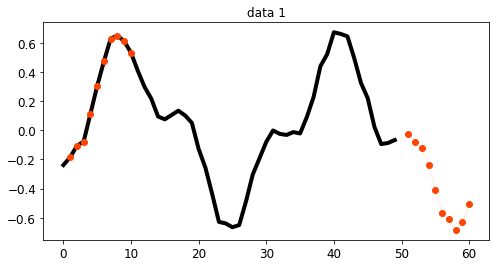

In [5]:
draw_data_points(1, x_valid, y_valid)

### 공통 loss 함수 설정

In [15]:
def last_time_step_mse(y_true, y_pred):
    return tf.keras.metrics.mean_squared_error(y_true[:, -1], y_pred[:, -1])

# 15.4 긴 시퀀스 다루기

## 15.4.1 불안정한 그레디언트와 싸우기 (614p)

### Layer normalization rnn cell 만들기

In [16]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

####  build model

In [17]:
def build_lnrnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                         input_shape=[None, 1]),
        tf.keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))
    ])
    model.summary()
    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    
    return model

## 15.4.2 단기기억문제 해결하기 (617p)

### LSTM( Long short-term memory )
![GRU](./images/LSTM.jpeg)

#### build model

In [18]:
def build_lstm():
    model = models.Sequential([
        layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        layers.LSTM(20, return_sequences=True),
        layers.TimeDistributed(layers.Dense(10))
    ])
    
    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    model.summary()
    
    return model

### GRU( Gated recurrent unit )
![GRU](./images/GRU.jpeg)

#### build model

In [19]:
def build_gru():
    model = models.Sequential([
        layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        layers.GRU(20, return_sequences=True),
        layers.TimeDistributed(layers.Dense(10))
    ])

    model.summary()
    model.compile(loss="mse", optimizer="adam",metrics=[last_time_step_mse])
    
    return model

### Conv+GRU

#### build model

In [20]:
def build_conv_gru():
    model = models.Sequential([
        layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', 
                      input_shape=[None, 1]),
        layers.GRU(20, return_sequences=True),
        layers.GRU(20, return_sequences=True),
        layers.TimeDistributed(layers.Dense(10))
    ])
    model.summary()
    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    return model

### WaveNet
![wavenet](./images/WaveNet.png)

#### build model

In [21]:
def build_wavenet():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=[None, 1]))
    for rate in (1, 2, 4, 8) * 2:
        model.add(layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                      activation="relu", dilation_rate=rate))
    model.add(layers.Conv1D(filters=10, kernel_size=1))
    model.summary()    
    model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    return model

# 모델 학습

In [38]:
def train_eval(model, x_train, y_train, x_valid, y_valid, epoch=5):
    print("* Train")
    history = model.fit(x_train, y_train, epochs=epoch,
                        validation_data=(x_valid, y_valid))
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    print("* Evaluate ")
    model.evaluate(x_valid, y_valid)

def use_model(model, x_data, y_data):
    y_pred = model.predict(x_data)
    print(y_pred.shape, y_data.shape)
    draw_data_points(0, x_data, y_data, y_pred)

## LN RNN

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_8 (RNN)                  (None, None, 20)          480       
_________________________________________________________________
rnn_9 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________
* Train
Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 11s 2ms/sample - loss: 0.1495 - last_time_step_mse: 0.1344 - val_loss: 0.0714 - val_last_time_step_mse: 0.0607
Epoch 2/5
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0635 - last_time_step_mse: 0.0531 - val_loss: 0.0579 - val_last_time_step_mse: 0.

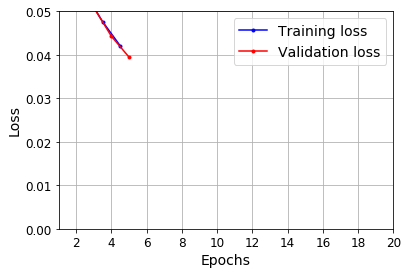

* Evaluate 
2000/2000 [==============================] - 0s 205us/sample - loss: 0.0395 - last_time_step_mse: 0.0245


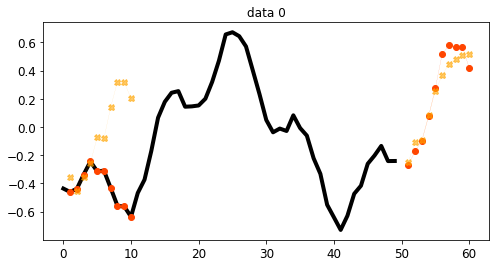

In [32]:
# 모델 선언
lnrnn = build_lnrnn()
# 모델 학습
train_eval(lnrnn, x_train, y_train, x_valid, y_valid, epoch=5)
# 모델 사용
use_model(lnrnn, x_valid, y_valid)

## LSTM

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________
* Train
Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 10s 1ms/sample - loss: 0.0756 - last_time_step_mse: 0.0610 - val_loss: 0.0541 - val_last_time_step_mse: 0.0354
Epoch 2/5
7000/7000 [==============================] - 8s 1ms/sample - loss: 0.0453 - last_time_step_mse: 0.0249 - val_loss: 0.0391 - val_last_time_step_mse: 0.

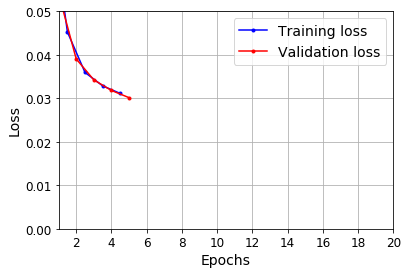

* Evaluate 
2000/2000 [==============================] - 0s 190us/sample - loss: 0.0302 - last_time_step_mse: 0.0122


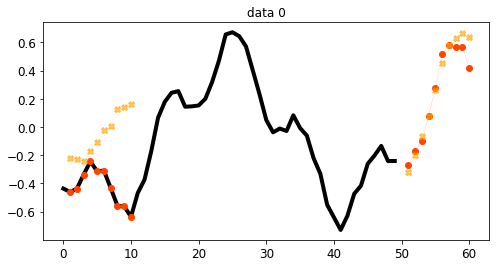

In [33]:
# 모델 선언
lstm = build_lstm()
# 모델 학습
train_eval(lstm, x_train, y_train, x_valid, y_valid, epoch=5)
# 모델 사용
use_model(lstm, x_valid, y_valid)

## GRU

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 20)          1380      
_________________________________________________________________
gru_5 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 10)          210       
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________
* Train
Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 12s 2ms/sample - loss: 0.0748 - last_time_step_mse: 0.0661 - val_loss: 0.0535 - val_last_time_step_mse: 0.0434
Epoch 2/5
7000/7000 [==============================] - 9s 1ms/sample - loss: 0.0484 - last_time_step_mse: 0.0378 - val_loss: 0.0450 - val_last_time_step_mse: 0

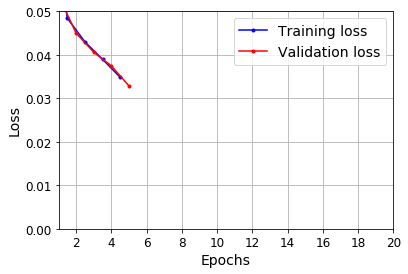

* Evaluate 
2000/2000 [==============================] - 0s 223us/sample - loss: 0.0328 - last_time_step_mse: 0.0193


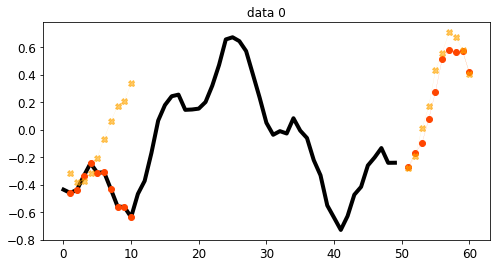

In [34]:
# 모델 선언
gru = build_gru()
# 모델 학습
train_eval(gru, x_train, y_train, x_valid, y_valid, epoch=5)
# 모델 사용
use_model(gru, x_valid, y_valid)

## Conv+GRU

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, None, 20)          100       
_________________________________________________________________
gru_10 (GRU)                 (None, None, 20)          2520      
_________________________________________________________________
gru_11 (GRU)                 (None, None, 20)          2520      
_________________________________________________________________
time_distributed_12 (TimeDis (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________
* Train
Train on 7000 samples, validate on 2000 samples
Epoch 1/5
7000/7000 [==============================] - 7s 1ms/sample - loss: 0.0741 - last_time_step_mse: 0.0677 - val_loss: 0.0449 - val_last_time_step_mse: 0.0369
Epoch 2/5
7000/7000 [=======

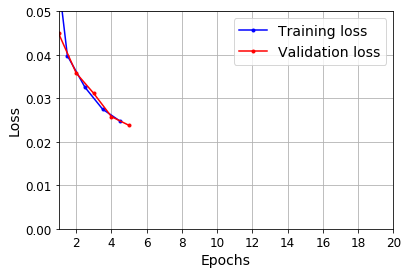

* Evaluate 
2000/2000 [==============================] - 0s 130us/sample - loss: 0.0238 - last_time_step_mse: 0.0127
(2000, 24, 10) (2000, 24, 10)


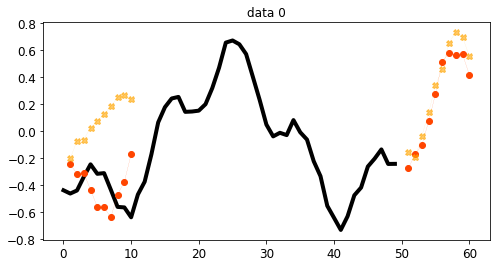

In [39]:
# 모델 선언
conv_gru = build_conv_gru()
# 모델 학습
train_eval(conv_gru, x_train, y_train[:,3::2], x_valid, y_valid[:,3::2], epoch=5)
# 모델 사용
use_model(conv_gru, x_valid, y_valid[:,3::2])

## WaveNet

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, None, 20)          60        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 20)        

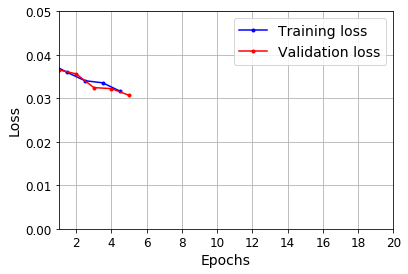

* Evaluate 
2000/2000 [==============================] - 0s 199us/sample - loss: 0.0307 - last_time_step_mse: 0.0167
(2000, 50, 10) (2000, 50, 10)


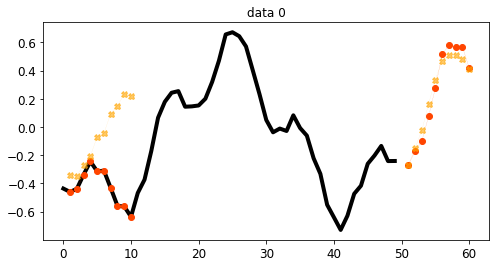

In [40]:
# 모델 선언
wavenet = build_wavenet()
# 모델 학습
train_eval(lnrnn, x_train, y_train, x_valid, y_valid, epoch=5)
# 모델 사용
use_model(lnrnn, x_valid, y_valid)